In [35]:
# read three pkl files and combine them into one
import pickle
import pandas as pd
import os
import logging
import matplotlib.pyplot as plt
from pathlib import Path
from src.constants import VTCPaths
from pyannote.metrics.detection import DetectionPrecisionRecallFMeasure, DetectionErrorRate
from pyannote.core import Annotation, Segment


In [36]:
def combine_pickles(folder_path: str, output_file_name: str) -> None:
    """
    Combines all pickle files in a folder into a single DataFrame and saves it to a new pickle file.

    Parameters:
    - folder_path (str): Path to the folder containing the pickle files.
    - output_path (str): Path to save the combined DataFrame as a pickle file.
    """
    # List to store individual DataFrames
    dataframes = []

    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.pkl'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'rb') as f:
                df = pickle.load(f)
                dataframes.append(df)

    # Combine all DataFrames into one
    combined_df = pd.concat(dataframes, ignore_index=True)

    output_path = os.path.join(folder_path, output_file_name)
    combined_df.to_pickle(output_path)
    
def rttm_to_dataframe(rttm_file: Path) -> pd.DataFrame:
    """
    This function reads the voice_type_classifier
    output rttm file and returns its content as a pandas DataFrame.

    Parameters
    ----------
    rttm_file : path
        the path to the RTTM file

    """
    logging.info(f"Reading RTTM file from: {rttm_file}")
    
    try:
        df = pd.read_csv(
            rttm_file,
            sep=" ",
            names=[
                "Speaker",
                "audio_file_name",
                "audio_file_id",
                "Utterance_Start",
                "Utterance_Duration",
                "NA_1",
                "NA_2",
                "Voice_type",
                "NA_3",
                "NA_4",
            ],
        )
    except Exception as e:
        logging.error(f"Failed to read RTTM file: {e}")
        raise
    
    logging.info("Successfully read RTTM file. Processing data...")

    # Drop unnecessary columns
    df = df.drop(columns=["Speaker", "audio_file_id", "NA_1", "NA_2", "NA_3", "NA_4"])  # noqa: E501
    df["Utterance_End"] = df["Utterance_Start"] + df["Utterance_Duration"]
    
    logging.info("Data processing complete. Returning DataFrame.")

    try:
        df.to_pickle(VTCPaths.df_output_pickle)
        logging.info(f"DataFrame successfully saved to: {VTCPaths.df_output_pickle}")
    except Exception as e:
        logging.error(f"Failed to save DataFrame to file: {e}")
        raise
    
def plot_annotations_vs_predictions(audio_file_name: str,
                                    prediction_file_name: str, 
                                    annotations_path: str = '/home/nele_pauline_suffo/ProcessedData/annotations_superannotate/quantex_share_annotations.pkl',
    ):
    annotations_df = pd.read_pickle(annotations_path)
    predictios_dir = '/home/nele_pauline_suffo/outputs/vtc/'
    predictions_path = os.path.join(predictios_dir, prediction_file_name)
    predictions_df = pd.read_pickle(predictions_path)

    # Strip the audio_file_name by removing the '_16kHz' extension and everything afterwards
    predictions_df['audio_file_name'] = predictions_df['audio_file_name'].str.split('_').str[0]

    example_annotation = annotations_df[annotations_df['audio_file_name'] == audio_file_name]
    example_prediction = predictions_df[predictions_df['audio_file_name'] == audio_file_name]

    # Set up the figure and axis
    plt.figure(figsize=(12, 2))
    ax = plt.gca()

    ground_truth_fem = example_annotation[example_annotation['Voice_type'] == 'FEM']
    ground_truth_mal = example_annotation[example_annotation['Voice_type'] == 'MAL']
    ground_truth_kchi = example_annotation[example_annotation['Voice_type'] == 'KCHI']
    ground_truth_och = example_annotation[example_annotation['Voice_type'] == 'OCH']
    ground_truth_speech = example_annotation[example_annotation['Voice_type'] == 'SPEECH']
    predictions_fem = example_prediction[example_prediction['Voice_type'] == 'FEM']
    predictions_mal = example_prediction[example_prediction['Voice_type'] == 'MAL']
    predictions_kchi = example_prediction[example_prediction['Voice_type'] == 'KCHI']
    predictions_och = example_prediction[example_prediction['Voice_type'] == 'OCH']
    predictions_speech = example_prediction[example_prediction['Voice_type'] == 'SPEECH']

    # Define y-positions for the two bars
    y_ground_truth_kchi = 9
    y_predictions_kchi = 8

    y_ground_truth_fem = 7
    y_predictions_fem = 6

    y_ground_truth_och = 5
    y_predictions_och = 4 

    y_ground_truth_mal = 3
    y_predictions_mal = 2

    y_ground_truth_speech = 1
    y_predictions_speech = 0

    # Plot predictions, excluding SPEECH
    for idx, row in predictions_fem.iterrows():
        ax.barh(y_predictions_fem, row['Utterance_Duration'], left=row['Utterance_Start'], color='blue', edgecolor='black', alpha=0.7)

    for idx, row in predictions_mal.iterrows():
        ax.barh(y_predictions_mal, row['Utterance_Duration'], left=row['Utterance_Start'], color='blue', edgecolor='black', alpha=0.7)

    for idx, row in predictions_kchi.iterrows():
        ax.barh(y_predictions_kchi, row['Utterance_Duration'], left=row['Utterance_Start'], color='blue', edgecolor='black', alpha=0.7)

    for idx, row in predictions_och.iterrows():
        ax.barh(y_predictions_och, row['Utterance_Duration'], left=row['Utterance_Start'], color='blue', edgecolor='black', alpha=0.7)

    for idx, row in predictions_speech.iterrows():
        ax.barh(y_predictions_speech, row['Utterance_Duration'], left=row['Utterance_Start'], color='blue', edgecolor='black', alpha=0.7)

    for idx, row in ground_truth_fem.iterrows():
        ax.barh(y_ground_truth_fem, row['Utterance_Duration'], left=row['Utterance_Start'], color='green', edgecolor='black', alpha=0.7)

    for idx, row in ground_truth_mal.iterrows():
        ax.barh(y_ground_truth_mal, row['Utterance_Duration'], left=row['Utterance_Start'], color='green', edgecolor='black', alpha=0.7)

    for idx, row in ground_truth_kchi.iterrows():
        ax.barh(y_ground_truth_kchi, row['Utterance_Duration'], left=row['Utterance_Start'], color='green', edgecolor='black', alpha=0.7)

    for idx, row in ground_truth_och.iterrows():
        ax.barh(y_ground_truth_och, row['Utterance_Duration'], left=row['Utterance_Start'], color='green', edgecolor='black', alpha=0.7)

    for idx, row in ground_truth_speech.iterrows():
        ax.barh(y_ground_truth_speech, row['Utterance_Duration'], left=row['Utterance_Start'], color='green', edgecolor='black', alpha=0.7)

    # Adjust y-axis ticks and labels
    ax.set_yticks([y_ground_truth_speech, y_predictions_speech, y_ground_truth_fem, y_predictions_fem, y_ground_truth_mal, y_predictions_mal, y_ground_truth_kchi, y_predictions_kchi, y_ground_truth_och, y_predictions_och])
    ax.set_yticklabels(["GT SPEECH", "Pred SPEECH", "GT FEM", "Pred FEM", "GT MAL", "Pred MAL", "GT KCHI", "Pred KCHI", "GT OCH", "Pred OCH"])

    # Add labels and titles
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Category")
    ax.set_title("Annotations vs Predictions")
    ax.set_xlim(0, 60)


def dataframe_to_annotation(df, label_column="Voice_type"):
    """
    Converts a DataFrame to a pyannote.core.Annotation object.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with 'Utterance_Start', 'Utterance_End', and a label column.
    - label_column (str): Column name for the labels (default: 'Voice_type').

    Returns:
    - Annotation: pyannote.core.Annotation object.
    """
    annotation = Annotation()
    for _, row in df.iterrows():
        start = float(row["Utterance_Start"])
        end = float(row["Utterance_End"])
        label = row[label_column]
        annotation[Segment(start, end)] = label
    return annotation

def compute_metrics(hypothesis_file_name: str,
                    reference_df_path: str='/home/nele_pauline_suffo/ProcessedData/annotations_superannotate/quantex_share_annotations.pkl',
    ):
    hypothesis_dir = Path('/home/nele_pauline_suffo/outputs/vtc/')
    hypothesis_path = hypothesis_dir / hypothesis_file_name
    # Load reference and hypothesis DataFrames
    reference_df = pd.read_pickle(reference_df_path)
    hypothesis_df = pd.read_pickle(hypothesis_path)

    # Strip the audio_file_name by removing the '_16kHz' extension and everything afterwards
    hypothesis_df['audio_file_name'] = hypothesis_df['audio_file_name'].str.split('_').str[0]
    
    # Get the list of audio files that have annotations
    annotated_files = reference_df['audio_file_name'].unique()
    # Filter the hypothesis DataFrame to only include these files
    predictions = hypothesis_df[hypothesis_df['audio_file_name'].isin(annotated_files)]
    
    voice_types = ['KCHI', 'OCH', 'FEM', 'MAL', 'SPEECH']
    class_metrics = {voice_type: {'precision': [], 'recall': [], 'f1_score': [], 'error_rate': []} for voice_type in voice_types}

    # Loop over each video
    for video in annotated_files:
        # Filter DataFrames for the current video
        reference_filtered = reference_df[reference_df['audio_file_name'] == video]
        predictions_filtered = predictions[predictions['audio_file_name'] == video]

        # Skip if there are no annotations for this video
        if reference_filtered.empty:
            print(f"No annotations available for video: {video}. Skipping.")
            continue

        # Now, compute metrics per class within this video
        for voice_type in voice_types:
            # Filter annotations for the current voice type
            ref_class_filtered = reference_filtered[reference_filtered['Voice_type'] == voice_type]
            hyp_class_filtered = predictions_filtered[predictions_filtered['Voice_type'] == voice_type]

            # Convert to pyannote Annotations
            reference_class_annotation = dataframe_to_annotation(ref_class_filtered)
            hypothesis_class_annotation = dataframe_to_annotation(hyp_class_filtered)

            # Initialize class-specific metrics
            detection_f1_class = DetectionPrecisionRecallFMeasure(collar=0, skip_overlap=False)
            error_rate_metric_class = DetectionErrorRate(collar=0, skip_overlap=False)

            # Compute the detection metrics for this class
            detection_f1_class(reference_class_annotation, hypothesis_class_annotation)
            error_rate_class = error_rate_metric_class(reference_class_annotation, hypothesis_class_annotation)

            # Retrieve precision, recall, and F1 score
            precision_class, recall_class, f1_score_class = detection_f1_class.compute_metrics()

            # Store the per-class results
            class_metrics[voice_type]['precision'].append(precision_class)
            class_metrics[voice_type]['recall'].append(recall_class)
            class_metrics[voice_type]['f1_score'].append(f1_score_class)
            class_metrics[voice_type]['error_rate'].append(error_rate_class)

    print("\nAveraged Metrics Per Class Over All Videos:")
    avg_f1_scores_per_class = []  # List to store avg F1 scores per class

    for voice_type in voice_types:
        precisions = class_metrics[voice_type]['precision']
        recalls = class_metrics[voice_type]['recall']
        f1_scores = class_metrics[voice_type]['f1_score']
        error_rates = class_metrics[voice_type]['error_rate']

        if precisions:
            avg_precision = sum(precisions) / len(precisions)
            avg_recall = sum(recalls) / len(recalls)
            avg_f1 = sum(f1_scores) / len(f1_scores)
            avg_error_rate = sum(error_rates) / len(error_rates)
        else:
            avg_precision = avg_recall = avg_f1 = avg_error_rate = 0

        avg_f1_scores_per_class.append(avg_f1)

        print(f"Class '{voice_type.upper()}':")
        print(f"  Precision: {avg_precision:.3f}")
        print(f"  Recall: {avg_recall:.3f}")
        print(f"  F1 Score: {avg_f1:.3f}")
        print(f"  Error Rate: {avg_error_rate:.3f}\n")
        
    # Calculate the final F1 score over all classes
    if avg_f1_scores_per_class:
        final_f1_score = sum(avg_f1_scores_per_class) / len(avg_f1_scores_per_class)
    else:
        final_f1_score = 0

    print(f"Final F1 Score over all classes: {final_f1_score:.3f}")

## Postprocess Annotation Files

In [ ]:


combine_pickles('/home/nele_pauline_suffo/ProcessedData/annotations_superannotate/', 'quantex_share_annotations.pkl')


## Postprocess Prediction File

In [ ]:
rttm_to_dataframe('/home/nele_pauline_suffo/projects/voice-type-classifier/output_voice_type_classifier/share/all.rttm')

## Plot Results

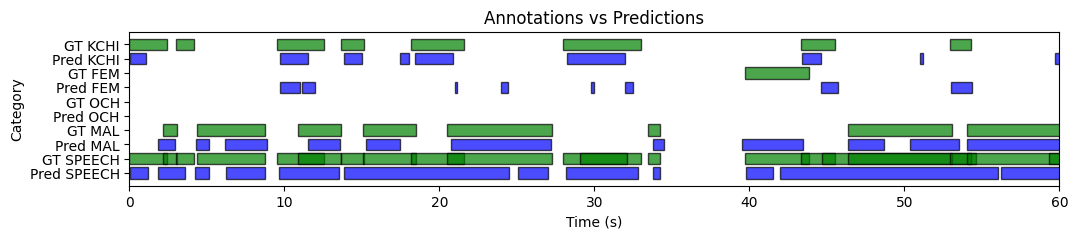

In [ ]:
plot_annotations_vs_predictions('672793', 'quantex_share_vtc_output_01.pkl')

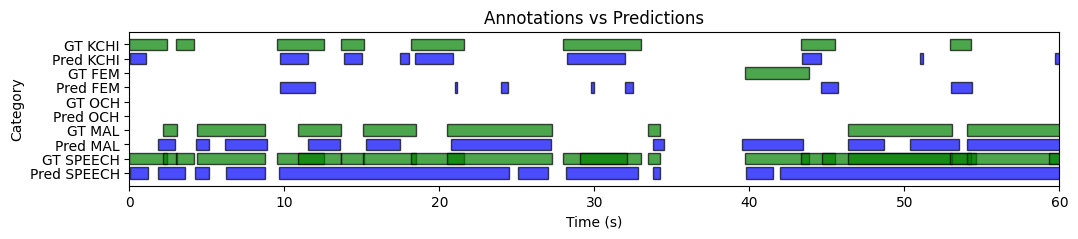

In [38]:
plot_annotations_vs_predictions('672793', 'quantex_share_vtc_output_03.pkl')

## Compute Evaluation Metrics

In [39]:
compute_metrics('quantex_share_vtc_output_01.pkl')

/home/nele_pauline_suffo/.conda/envs/pyannote/lib/python3.8/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(



Averaged Metrics Per Class Over All Videos:
Class 'KCHI':
  Precision: 0.779
  Recall: 0.526
  F1 Score: 0.591
  Error Rate: 0.725

Class 'OCH':
  Precision: 1.000
  Recall: 0.792
  F1 Score: 0.792
  Error Rate: 0.208

Class 'FEM':
  Precision: 0.325
  Recall: 0.644
  F1 Score: 0.334
  Error Rate: 6.666

Class 'MAL':
  Precision: 0.243
  Recall: 0.675
  F1 Score: 0.178
  Error Rate: 3.131

Class 'SPEECH':
  Precision: 0.780
  Recall: 0.682
  F1 Score: 0.683
  Error Rate: 1.798

Final F1 Score over all classes: 0.515


In [40]:
compute_metrics('quantex_share_vtc_output_03.pkl')

/home/nele_pauline_suffo/.conda/envs/pyannote/lib/python3.8/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(



Averaged Metrics Per Class Over All Videos:
Class 'KCHI':
  Precision: 0.778
  Recall: 0.532
  F1 Score: 0.595
  Error Rate: 0.723

Class 'OCH':
  Precision: 1.000
  Recall: 0.792
  F1 Score: 0.792
  Error Rate: 0.208

Class 'FEM':
  Precision: 0.324
  Recall: 0.650
  F1 Score: 0.335
  Error Rate: 6.784

Class 'MAL':
  Precision: 0.244
  Recall: 0.676
  F1 Score: 0.179
  Error Rate: 3.158

Class 'SPEECH':
  Precision: 0.779
  Recall: 0.692
  F1 Score: 0.688
  Error Rate: 1.810

Final F1 Score over all classes: 0.518


In [41]:
compute_metrics('quantex_share_vtc_output_20.pkl')

/home/nele_pauline_suffo/.conda/envs/pyannote/lib/python3.8/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(



Averaged Metrics Per Class Over All Videos:
Class 'KCHI':
  Precision: 0.751
  Recall: 0.653
  F1 Score: 0.657
  Error Rate: 0.707

Class 'OCH':
  Precision: 1.000
  Recall: 0.792
  F1 Score: 0.792
  Error Rate: 0.208

Class 'FEM':
  Precision: 0.305
  Recall: 0.768
  F1 Score: 0.353
  Error Rate: 8.782

Class 'MAL':
  Precision: 0.240
  Recall: 0.703
  F1 Score: 0.189
  Error Rate: 3.533

Class 'SPEECH':
  Precision: 0.751
  Recall: 0.822
  F1 Score: 0.742
  Error Rate: 2.013

Final F1 Score over all classes: 0.547
